In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")
# Importing GemPy
import gempy as gp
# Embedding matplotlib figures in the notebooks
%matplotlib inline
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt


C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

In [2]:
# set resolution, extent and input data
geo_data = gp.create_data([0,1000,0,50,0,1000],resolution=[20,2,30], 
                        path_o = os.pardir+"/data/input_data/jan_models/model1_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model1_surface_points.csv") 

Active grids: ['regular']


In [3]:
# define series and assign surfaces
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [4]:
# define the interpolator
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


In [5]:
#calcualte the solution
sol = gp.compute_model(geo_data)

../..\gempy\core\solution.py:258: UserWarning: Surfaces not computed due to: marching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Surfaces not computed due to: ' + str(e))
../..\gempy\core\solution.py:258: UserWarning: Surfaces not computed due to: marching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Surfaces not computed due to: ' + str(e))


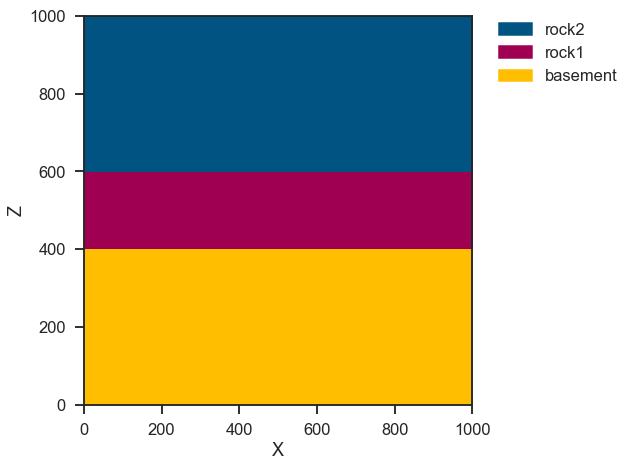

In [6]:
# Plot cross section, which is basically the whole model in this example
gp.plot.plot_section(geo_data, cell_number=0)

In [7]:
import gempy as gp
#importlib.reload(kriging)
from gempy.assets import kriging

In [8]:
test_data = np.array([[110,0,510,2],[910,0,510,1],[510,0,530,1],[310,0,410,5]])

In [9]:
# Creating a kriging object with model solution and input domain (by id) and conditioning data
kriging_model = kriging.kriging_model(model=sol, domain=[1],data=test_data)

kriging_model.krig_grid = np.round(kriging_model.krig_grid,0)

# set some parameters, not final yet
kriging_model.range_ = 200
kriging_model.moving_neighbourhood  = 'all'
kriging_model.set_kriging_type('OK')
kriging_model.nugget = 2
kriging_model.sill = np.var(test_data[:,3])

kriging_model.create_kriged_field()
#kriging_model.results_df.head()

In [10]:
kriging_model.data

array([[110,   0, 510,   2],
       [910,   0, 510,   1],
       [510,   0, 530,   1],
       [310,   0, 410,   5]])

In [11]:
kriging_model.results_df.shape

(480, 5)

In [12]:
kriging_model.krig_grid.shape

(480, 3)

In [13]:
kriging_model.krig_lith.shape

(480,)

In [14]:
geo_data.solutions.lith_block[kriging_model.mask].shape

(480,)

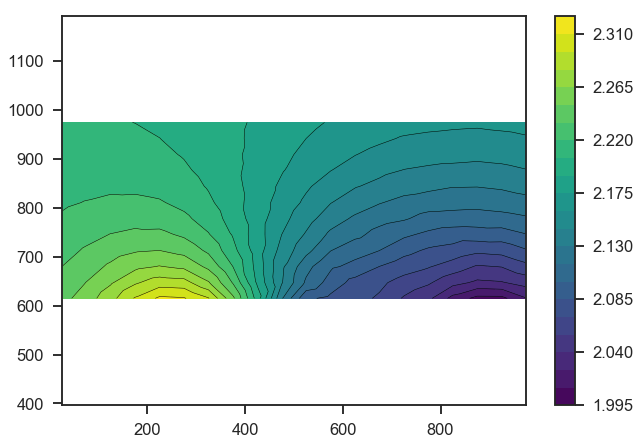

In [20]:

x = kriging_model.results_df['X'].values
y = kriging_model.results_df['Z'].values
prop = kriging_model.results_df['est_value'].values
var = kriging_model.results_df['est_variance'].values


fig1, ax1 = plt.subplots()
ax1.axis('equal')


tcf = ax1.tricontourf(x, y, prop, 20, cmap='viridis')
tcf_lines = ax1.tricontour(x, y, prop, 20, linewidths=0.5, colors='k')
fig1.colorbar(tcf)
plt.show()

In [21]:
prop.shape

(480,)

In [23]:
def plot_block_section(self, cell_number:int, block:np.ndarray=None, direction:str="y",
                       interpolation:str='none', show_data:bool=False, show_faults:bool=False, show_topo:bool=False,
                       block_type=None, ve:float=1, solution= None, **kwargs):
    if block is None:
        _block = solution.lith_block
    else:
        _block = block
        if _block.dtype == bool:
            kwargs['cmap'] = 'viridis'
            kwargs['norm'] = None

    if block_type is not None:
        raise NotImplementedError

    plot_block = _block.reshape(self.model.grid.regular_grid.resolution[0],
                                self.model.grid.regular_grid.resolution[1],
                                self.model.grid.regular_grid.resolution[2])
    _a, _b, _c, extent_val, x, y = self._slice(direction, cell_number)[:-2]

    if show_data:
        self.plot_data(direction, 'all')
    # TODO: plot_topo option - need fault_block for that

    # apply vertical exageration
    if direction in ("x", "y"):
        aspect = ve
    else:
        aspect = 1

    if 'cmap' not in kwargs:
        kwargs['cmap'] = self._cmap
    if 'norm' not in kwargs:
        kwargs['norm'] = self._norm

    im = plt.imshow(plot_block[_a, _b, _c].T,
                    origin="bottom",
                    extent=extent_val,
                    interpolation=interpolation,
                    aspect=aspect,
                    **kwargs)

    if extent_val[3] < 0:           # correct vertical orientation of plot
        plt.gca().invert_yaxis()    # if maximum vertical extent negative

    if show_faults:
        self.extract_fault_lines(cell_number, direction)

    if show_topo:
        if self.model.grid.topography is not None:
            if direction == 'z':
                plt.contour(self.model.grid.topography.values_3D[:, :, 2], extent=extent_val, cmap='Greys')
            else:
                self.plot_topography(cell_number=cell_number, direction=direction)

    if not show_data:
        import matplotlib.patches as mpatches
        patches = [mpatches.Patch(color=color, label=surface) for surface, color in self._color_lot.items()]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.xlabel(x)
    plt.ylabel(y)
    return plt.gcf()


In [28]:
block = geo_data.solutions.lith_block
block[np.where(kriging_model.mask == True)] = prop

In [33]:
block

array([3.        , 3.        , 3.        , ..., 2.16095494, 2.16436534,
       2.16747924])

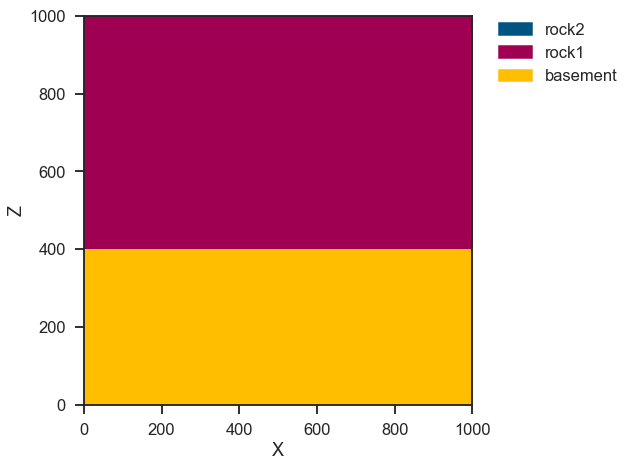

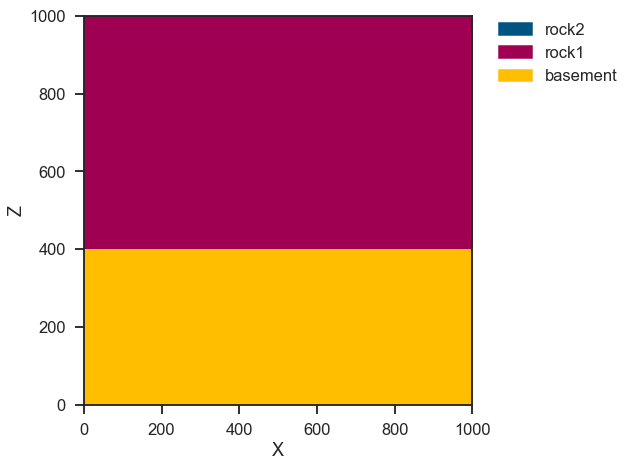

In [37]:
plot_block_section(plot, block=geo_data.solutions.lith_block, cell_number=0, direction='y')

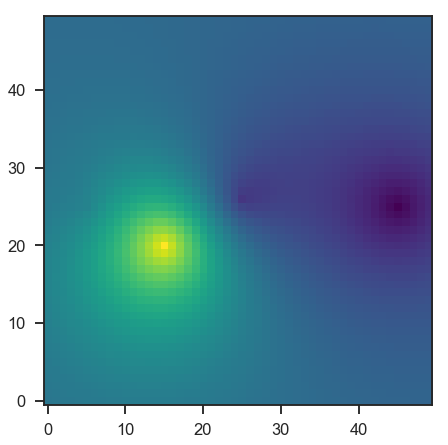

In [34]:
plt.imshow(prop.reshape(geo_data.grid.regular_grid.resolution)[:,0,:].T, origin='lower', cmap='viridis')

In [36]:
# Creating a kriging object with model solution and input domain (by id) and conditioning data
#kriging_model = kriging.kriging_model(model=sol, domain=[2],data=test_data)

#kriging_model.krig_grid = np.round(kriging_model.krig_grid,0)

# change moving neighbourhood for simulation
kriging_model.moving_neighbourhood  = 'n_closest'


kriging_model.create_gaussian_field()

kriging_model.results_sim_df.head()

,X,Y,Z,sim_value,est_variance
0,650.0,0.0,470.0,3.121114,3.089526
1,230.0,0.0,410.0,4.208958,2.873021
2,910.0,0.0,430.0,2.173077,2.921382
3,10.0,0.0,450.0,2.480378,2.911834
4,590.0,0.0,530.0,2.406172,2.697007


In [35]:
# results_df and results_sim_df are basically all you need for plotting I guess (hope)
# (plus maybe the solution (sol) that I pass to the object)

# 2D section plotting:
# - as for gempy section
# - either value or variance
# - either results or simulation results (if calculated)
# - either contourf or block
# - plot on section of model (maybe change colors of background model)
# - allow to plot on subplot if thats not automatically possible

# 3D Plotting
# - Most useful and cool for first run would be block model
# - allow threshhold to show only certain blocks

# variogram/covariance function plotting (Jan)
# - easily plot used function 
# - show nugget range and sill 
# - allow to plot on subplot if thats not automatically possible
